<a href="https://colab.research.google.com/github/prasannakumar2012/spark_experiments/blob/master/examples/Delta_Lake_Tables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
!pip -q install findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages io.delta:delta-core_2.12:0.7.0 --conf spark.sql.extensions=io.delta.sql.DeltaSparkSessionExtension --conf spark.sql.catalog.spark_catalog=org.apache.spark.sql.delta.catalog.DeltaCatalog pyspark-shell'


In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.appName('delta_session').getOrCreate()

In [ ]:
# from google.colab.output import eval_js
# print(eval_js("google.colab.kernel.proxyPort(4040)"))

To Check the Spark UI, open the URL printed by running the above command : https://######/jobs/, /SQL/




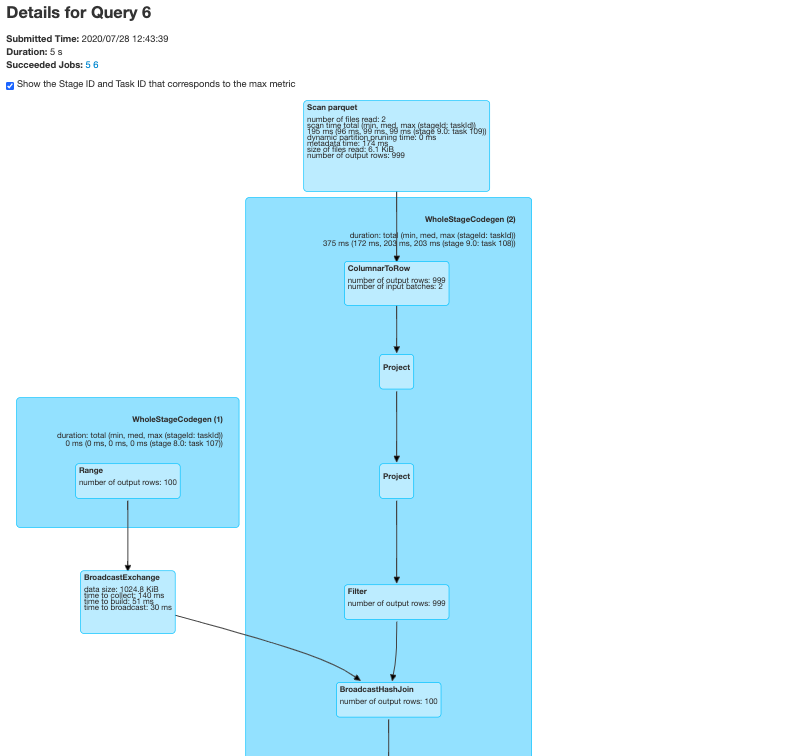

In [5]:
history = spark.range(1,1000)
history = history.withColumn("type", lit("history"))
history.show()

+---+-------+
| id|   type|
+---+-------+
|  1|history|
|  2|history|
|  3|history|
|  4|history|
|  5|history|
|  6|history|
|  7|history|
|  8|history|
|  9|history|
| 10|history|
| 11|history|
| 12|history|
| 13|history|
| 14|history|
| 15|history|
| 16|history|
| 17|history|
| 18|history|
| 19|history|
| 20|history|
+---+-------+
only showing top 20 rows



In [7]:
# history.write.format("delta").save("delta_sample_data")
history.write.format("delta").saveAsTable("delta_sample_data_tab")

In [8]:
spark.sql("show  tables").show(truncate=False)

+--------+---------------------+-----------+
|database|tableName            |isTemporary|
+--------+---------------------+-----------+
|default |delta_sample_data_tab|false      |
+--------+---------------------+-----------+



In [9]:
spark.sql("describe detail delta_sample_data_tab").show(truncate=False)

+------+------------------------------------+-----------------------------+-----------+---------------------------------------------------+-----------------------+-----------------------+----------------+--------+-----------+----------+----------------+----------------+
|format|id                                  |name                         |description|location                                           |createdAt              |lastModified           |partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|
+------+------------------------------------+-----------------------------+-----------+---------------------------------------------------+-----------------------+-----------------------+----------------+--------+-----------+----------+----------------+----------------+
|delta |9d27b91d-6ec9-4463-8ae4-524ea1cfda4d|default.delta_sample_data_tab|null       |file:/content/spark-warehouse/delta_sample_data_tab|2020-08-11 09:24:02.226|2020-08-11 09:24:03.746|

In [10]:
!ls -l /content/spark-warehouse/delta_sample_data_tab

total 12
drwxr-xr-x 2 root root 4096 Aug 11 09:24 _delta_log
-rw-r--r-- 1 root root 3484 Aug 11 09:24 part-00000-67c839e9-fbd4-4a31-87f7-cb23b67a6700-c000.snappy.parquet
-rw-r--r-- 1 root root 2746 Aug 11 09:24 part-00001-c022e469-e695-430c-82b3-342f4b27c876-c000.snappy.parquet


In [11]:
updates = spark.range(100,200)
updates = updates.withColumn("type", lit("updates"))
updates.createOrReplaceTempView("updates")
updates.show()

+---+-------+
| id|   type|
+---+-------+
|100|updates|
|101|updates|
|102|updates|
|103|updates|
|104|updates|
|105|updates|
|106|updates|
|107|updates|
|108|updates|
|109|updates|
|110|updates|
|111|updates|
|112|updates|
|113|updates|
|114|updates|
|115|updates|
|116|updates|
|117|updates|
|118|updates|
|119|updates|
+---+-------+
only showing top 20 rows



In [12]:
spark.sql("""MERGE INTO delta_sample_data_tab history
  using updates  
  on history.id = updates.id
  WHEN MATCHED THEN UPDATE SET * 
  WHEN NOT MATCHED THEN INSERT * """)

DataFrame[]

In [13]:
spark.sql("""
describe history delta_sample_data_tab
""").show(truncate=False)

+-------+-----------------------+------+--------+----------------------+------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|version|timestamp              |userId|userName|operation             |operationParameters                                                     |job |notebook|clusterId|readVersion|isolationLevel|isBlindAppend|operationMetrics                                                                                                                                                                                                    |userMetadata|
+-------+-----------------------+------+--------+----------------------+------------------------------------------------------

In [14]:
spark.sql("""
select type, count(*) as type_count from delta_sample_data_tab group by type
""").show(truncate=False)

+-------+----------+
|type   |type_count|
+-------+----------+
|updates|100       |
|history|899       |
+-------+----------+



In [ ]:
# from delta.tables import *
# deltaTable = DeltaTable.forPath(spark, "delta_sample_data")
# deltaTable.alias("history").merge(
#     updates.alias("updates"),
#     "history.id = updates.id").whenMatchedUpdateAll().whenNotMatchedInsertAll().execute()

In [32]:
# deltaTable.history().show(truncate=False)

In [33]:
# spark.sql("describe detail 'delta_sample_data'").show(truncate=False)

In [34]:
# spark.read.format("delta").load("delta_sample_data").groupBy("type").count().show()